[Open in Colab](https://colab.research.google.com/github/pywavelet/pywavelet/blob/main/docs/examples/backends.ipynb)

# Backend comparison

In [ ]:
!pip install pywavelet

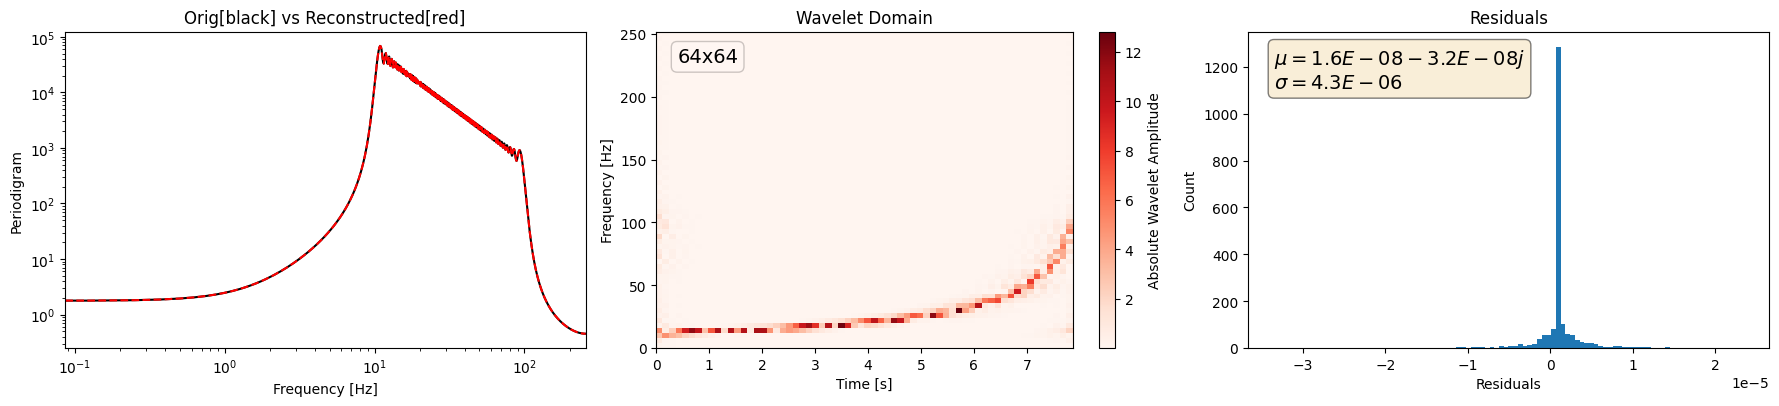

In [18]:
from scipy.signal import chirp
import numpy as np
from typing import List
import matplotlib.pyplot as plt

from pywavelet.types import TimeSeries
from pywavelet.transforms import from_freq_to_wavelet, from_wavelet_to_freq


def generate_chirp_time_domain_signal(
    t: np.ndarray, freq_range: List[float]
) -> TimeSeries:
    fs = 1 / (t[1] - t[0])
    nyquist = fs / 2
    fmax = max(freq_range)
    assert (
        fmax < nyquist
    ), f"f_max [{fmax:.2f} Hz] must be less than f_nyquist [{nyquist:2f} Hz]."

    y = chirp(
        t, f0=freq_range[0], f1=freq_range[1], t1=t[-1], method="hyperbolic"
    )
    return TimeSeries(data=y, time=t)


def plot_residuals(ax, residuals):
    ax.hist(residuals, bins=100)
    # add textbox of mean and std
    mean = residuals.mean()
    std = residuals.std()
    textstr = f"$\mu={mean:.1E}$\n$\sigma={std:.1E}$"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    ax.text(
        0.05,
        0.95,
        textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=props,
    )
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Count")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    return ax


def plot(h_freq, h_reconstructed, h_wavelet, fname="roundtrip_time.png"):
    # Plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    _ = h_freq.plot_periodogram(ax=axes[0], color="black")
    _ = h_reconstructed.plot_periodogram(ax=axes[0], ls="--", color="red")
    _ = h_wavelet.plot(ax=axes[1], absolute=True, cmap="Reds")
    _ = plot_residuals(axes[2], h_freq.data - h_reconstructed.data)
    axes[0].set_title("Orig[black] vs Reconstructed[red]")
    axes[1].set_title("Wavelet Domain")
    axes[2].set_title("Residuals")
    fig.savefig(fname)
    # plt.close()
    plt.show()


# Sizes
dt = 1 / 512
Nt, Nf = 2**6, 2**6
mult = 16
freq_range = (10, 0.2 * (1 / dt))
ND = Nt * Nf

# time grid
ts = np.arange(0, ND) * dt
h_time = generate_chirp_time_domain_signal(ts, freq_range)
h_freq = h_time.to_frequencyseries()
h_wavelet = from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
h_reconstructed = from_wavelet_to_freq(h_wavelet, dt=dt)
plot(h_freq, h_reconstructed, h_wavelet, fname="roundtrip_time.png")

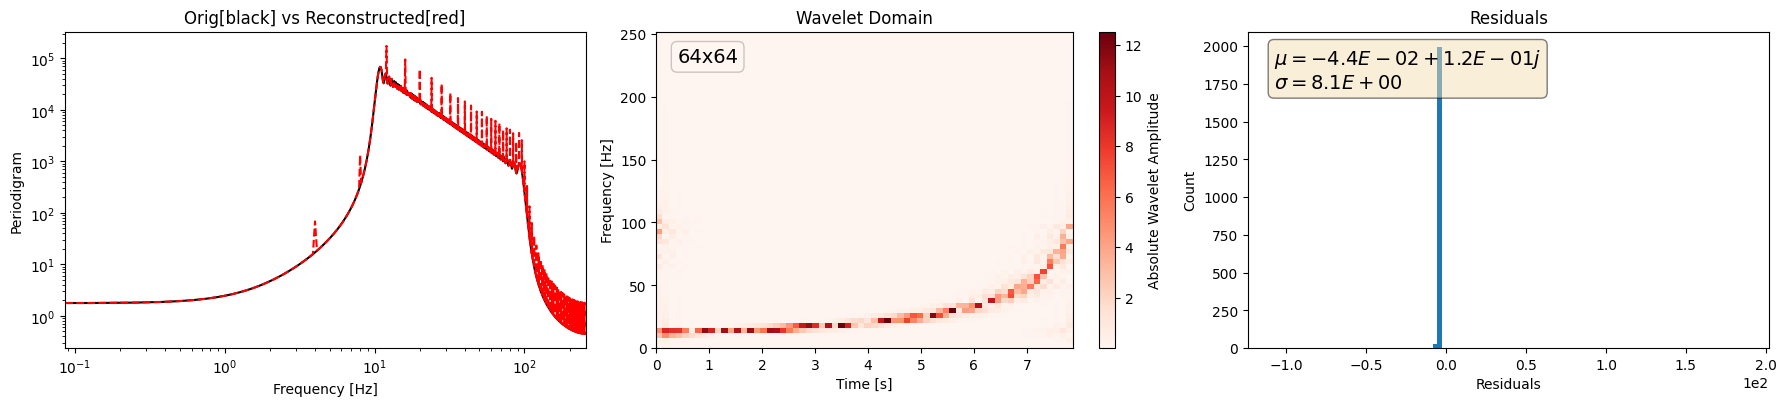

In [19]:
# using JAX

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

from pywavelet.transforms.jax import (
    from_freq_to_wavelet as jax_from_freq_to_wavelet,
)
from pywavelet.transforms.jax import (
    from_wavelet_to_freq as jax_from_wavelet_to_freq,
)

jax_h_wavelet = jax_from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
jax_h_reconstructed = jax_from_wavelet_to_freq(h_wavelet, dt=dt)
plot(
    h_freq, jax_h_reconstructed, jax_h_wavelet, fname="jax_roundtrip_time.png"
)

In [ ]:
from pywavelet.transforms.cupy import (
    from_freq_to_wavelet as cp_from_freq_to_wavelet,
)
from pywavelet.transforms.cupy import (
    from_wavelet_to_freq as cp_from_wavelet_to_freq,
)

cp_h_wavelet = jax_from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
cp_h_reconstructed = jax_from_wavelet_to_freq(h_wavelet, dt=dt)
plot(h_freq, cp_h_reconstructed, cp_h_wavelet, fname="cp_roundtrip_time.png")